# Test technique Quantmetry

Ce notebook présente le code développé dans le cadre du test technique de Quantmetry. On utilise `Python 3.7.8`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, shapiro, levene, f_oneway, spearmanr
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, precision_recall_curve, plot_precision_recall_curve
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC

## Statistiques descriptives

On commence par étudier le jeu de données afin de décrire sa structure et de traiter d'éventuelles données manquantes ou aberrantes.

### Exploration et description du jeu de données

In [2]:
# Chargement des données et vérification des valeurs manquantes
df = pd.read_csv('data_v1.0 (3).csv')
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20000 non-null  int64  
 1   index       20000 non-null  int64  
 2   date        19909 non-null  object 
 3   cheveux     19897 non-null  object 
 4   age         19909 non-null  float64
 5   exp         19904 non-null  float64
 6   salaire     19905 non-null  float64
 7   sexe        19900 non-null  object 
 8   diplome     19890 non-null  object 
 9   specialite  19907 non-null  object 
 10  note        19886 non-null  float64
 11  dispo       19894 non-null  object 
 12  embauche    20000 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 2.0+ MB
None
Unnamed: 0      0
index           0
date           91
cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo      

In [3]:
# On enlève les lignes où au moins une des valeurs est manquante (979 lignes / 20000)
df = df.dropna(axis=0, how='any')
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19021 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19021 non-null  int64  
 1   index       19021 non-null  int64  
 2   date        19021 non-null  object 
 3   cheveux     19021 non-null  object 
 4   age         19021 non-null  float64
 5   exp         19021 non-null  float64
 6   salaire     19021 non-null  float64
 7   sexe        19021 non-null  object 
 8   diplome     19021 non-null  object 
 9   specialite  19021 non-null  object 
 10  note        19021 non-null  float64
 11  dispo       19021 non-null  object 
 12  embauche    19021 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 2.0+ MB
None
Unnamed: 0    0
index         0
date          0
cheveux       0
age           0
exp           0
salaire       0
sexe          0
diplome       0
specialite    0
note          0
dispo         0
embauche      0
d

In [4]:
# On observe le format des premières lignes du jeu de données
df.head()

Unnamed: 0  index        date  cheveux   age   exp  salaire sexe  diplome  \
0           0      0  2012-06-02     roux  25.0   9.0  26803.0    F  licence   
1           1      1  2011-04-21    blond  35.0  13.0  38166.0    M  licence   
2           2      2  2012-09-07    blond  29.0  13.0  35207.0    M  licence   
4           4      4  2012-08-07     roux  35.0   6.0  28533.0    F  licence   
5           5      5  2014-02-12  chatain  37.0   8.0  38558.0    M   master   

  specialite   note dispo  embauche  
0   geologie  97.08   non         0  
1     forage  63.86   non         0  
2   geologie  78.50   non         0  
4  detective  81.91   non         0  
5   geologie  63.46   non         1

In [5]:
# On voit qu'il y a des données aberrantes dans les colonnes age et exp (valeurs négatives)
print(df['age'].describe())
print(df['exp'].describe())

count    19021.000000
mean        34.998791
std          9.606263
min         -3.000000
25%         29.000000
50%         35.000000
75%         41.000000
max         72.000000
Name: age, dtype: float64
count    19021.000000
mean         9.496662
std          3.012915
min         -2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         23.000000
Name: exp, dtype: float64


In [6]:
# On retire les lignes aberrantes en utilisant les conditions décrites dans la Section 2.1 du rapport
df = df[df['exp'] > 0]
df = df[df['age'] > 15.9]
df = df[df['age'] > df['exp'] + 15.9]
df = df[(df['diplome'] == 'bac') |
    ((df['age'] > 17.9) & (df['diplome'] == 'licence'))
    | ((df['age'] > 19.9) & (df['diplome'] == 'master'))
    | ((df['age'] > 21.9) & (df['diplome'] == 'doctorat'))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15986 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15986 non-null  int64  
 1   index       15986 non-null  int64  
 2   date        15986 non-null  object 
 3   cheveux     15986 non-null  object 
 4   age         15986 non-null  float64
 5   exp         15986 non-null  float64
 6   salaire     15986 non-null  float64
 7   sexe        15986 non-null  object 
 8   diplome     15986 non-null  object 
 9   specialite  15986 non-null  object 
 10  note        15986 non-null  float64
 11  dispo       15986 non-null  object 
 12  embauche    15986 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 1.7+ MB


In [7]:
# On rassemble les noms de colonnes par type
categorical_features = ['cheveux', 'sexe', 'diplome', 'specialite', 'dispo']
numerical_features = ['age', 'exp', 'salaire', 'note']
date_feature = ['date']

Pour chaque variable catégorielle, on trace trois graphes:
+ Un graphe qui représente les effectifs de chaque classe, qui permet de savoir si le jeu de données est équilibré.
+ Un graphe qui présente le nombre d'embauches pour chacune des classes, qui permet de voir si certaines combinaisons classe/embauche ne sont pas sous-représentées.
+ Un graphe qui représente la proportion d'embauches selon la classe de la variable, qui permet d'avoir une première visualisation des variables qui semblent pertinentes en vue de la prédiction de l'embauche d'un candidat.

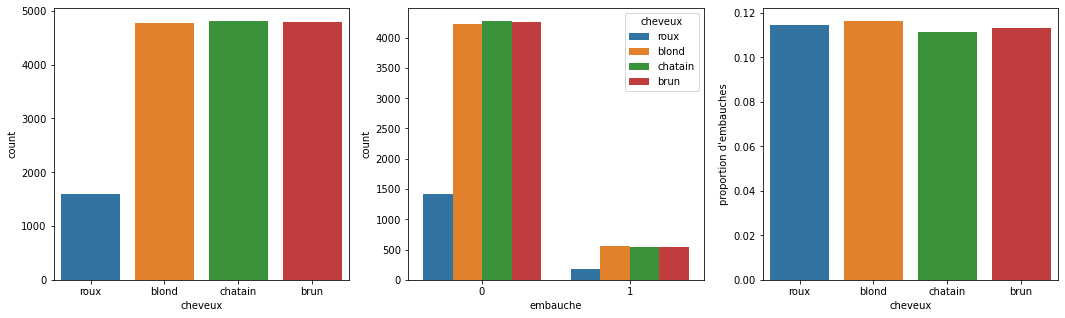

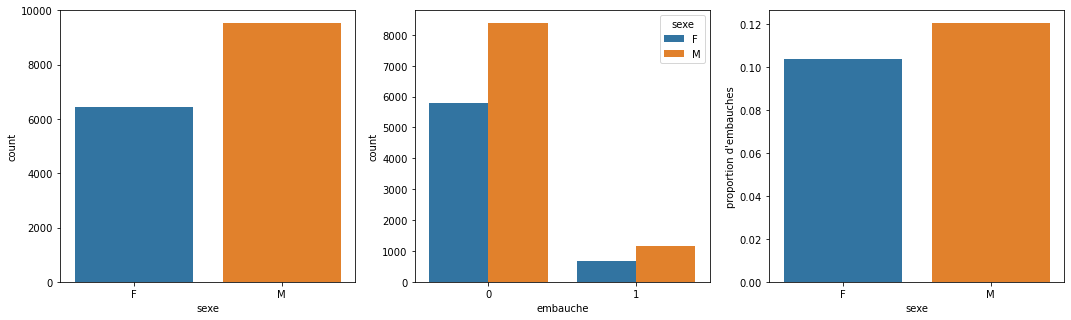

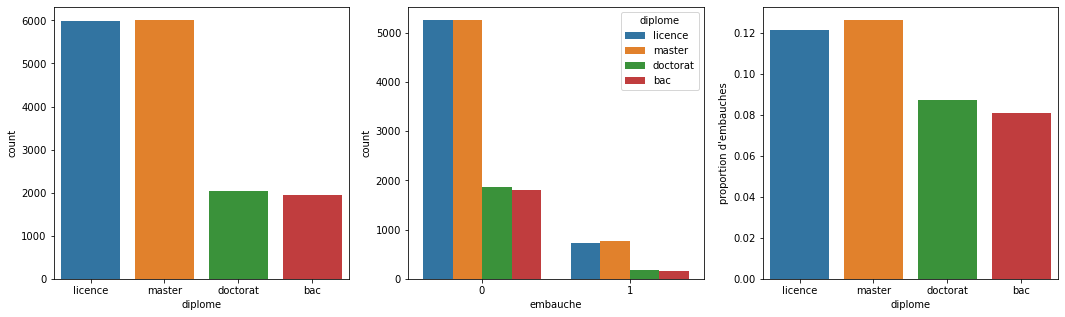

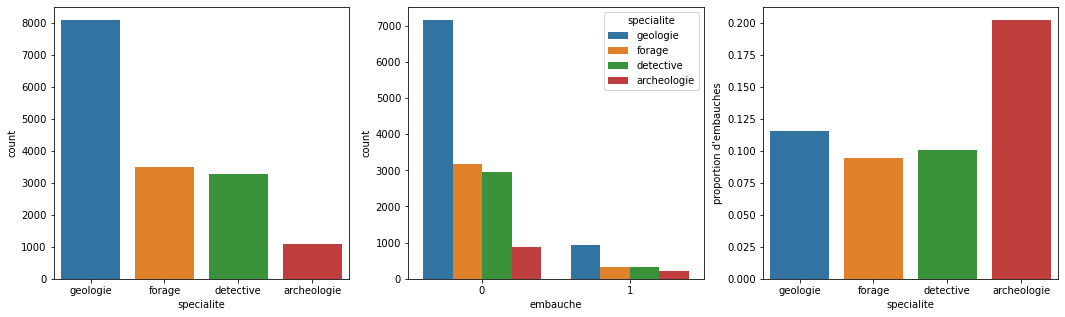

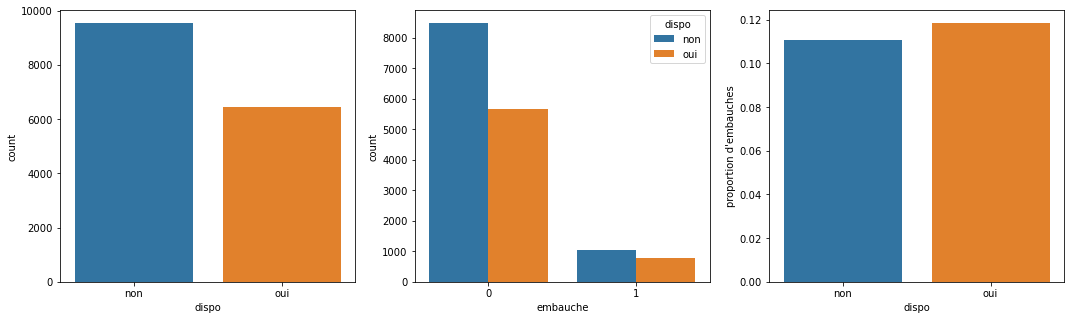

In [8]:
for cat_feat in categorical_features:
    categories = df[cat_feat].unique()

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    sns.countplot(x=cat_feat, data=df, ax=ax[0], order=categories)
    sns.countplot(x='embauche', hue=cat_feat, data=df, order=[0, 1], ax=ax[1])
    mean_embauche = df[[cat_feat, 'embauche']].groupby([cat_feat], as_index=False).mean()
    sns.barplot(x=cat_feat, y='embauche', data=mean_embauche, ax=ax[2], order=categories)

    ax[2].set_ylabel('proportion d\'embauches')

Pour chaque variable continue, on trace trois graphes:
+ Le graphe la distribution de la variable.
+ Le nombre d'embauches et de rejets en fonction de la variable considéree.
+ La distribution de la variable d'intérêt conditionnellement à l'embauche ou non. 

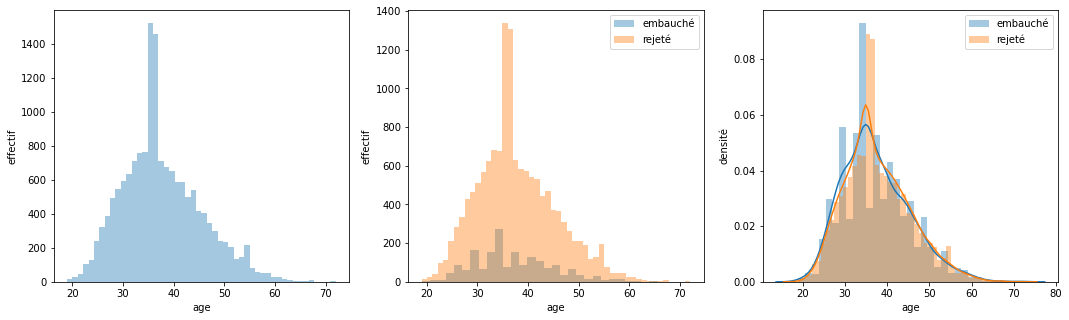

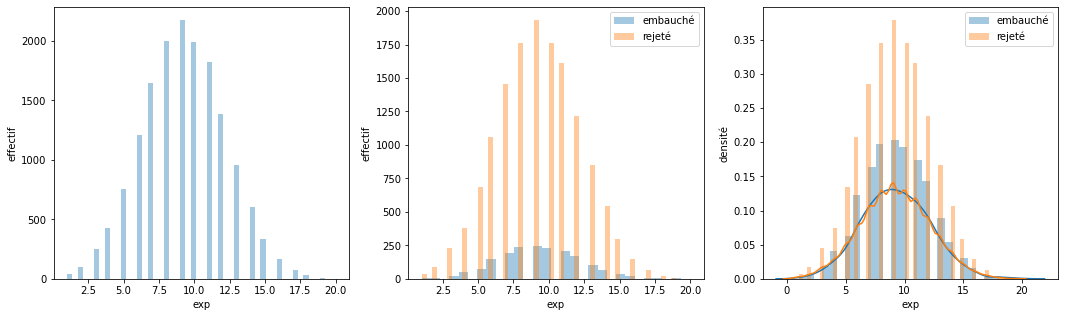

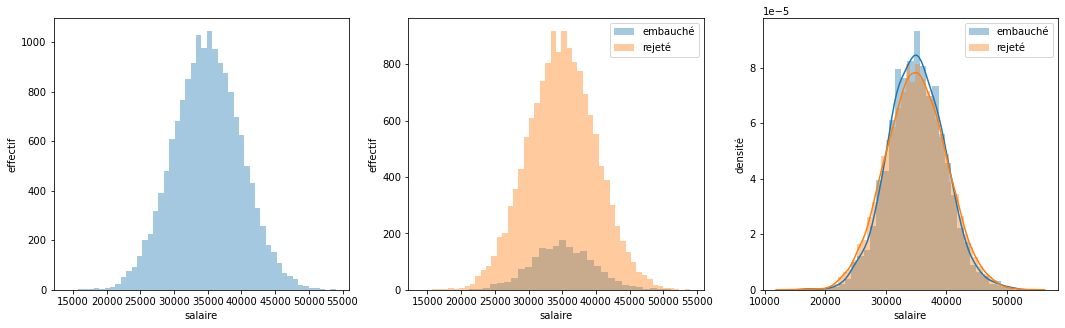

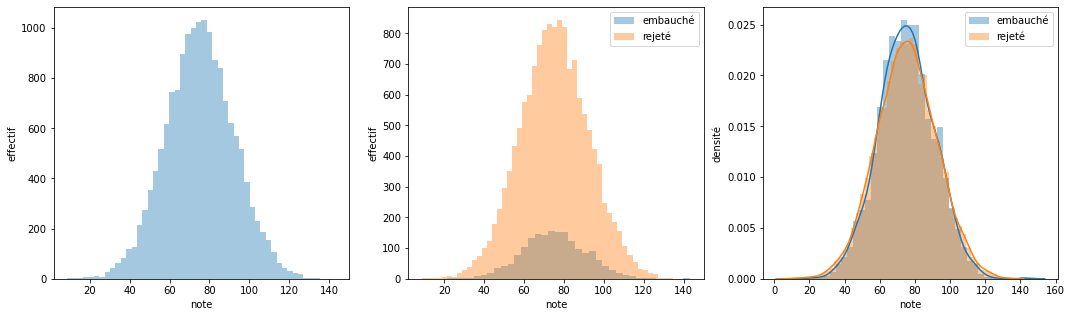

In [9]:
for num_feat in numerical_features:
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    sns.distplot(df[num_feat], ax=ax[0], kde=False)
    ax[0].set_ylabel('effectif')

    sns.distplot(df[df['embauche'] == 1][num_feat], ax=ax[1], kde=False, norm_hist=False, label='embauché')
    sns.distplot(df[df['embauche'] == 0][num_feat], ax=ax[1], kde=False, norm_hist=False, label='rejeté')
    ax[1].legend()    
    ax[1].set_ylabel('effectif')

    sns.distplot(df[df['embauche'] == 1][num_feat], ax=ax[2], kde=True, norm_hist=True, label='embauché')
    sns.distplot(df[df['embauche'] == 0][num_feat], ax=ax[2], kde=True, norm_hist=True, label='rejeté')
    ax[2].legend()
    ax[2].set_ylabel('densité')

On analyse maintenant les données temporelles pour savoir s'il y a des périodes qui ont été favorables à l'embauche.

In [10]:
# On convertit les données de date au format datetime et on crée de nouvelles colonnes pour stocker l'année, le mois et le jour.
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day

Pour chacune des variables `year`, `month`, `day`, on trace trois graphes:
+ Le nombre de candidatures en fonction de la période.
+ Le nombre d'embauches en fonction de la période.
+ La proportion d'embauches en fonction de la période. 

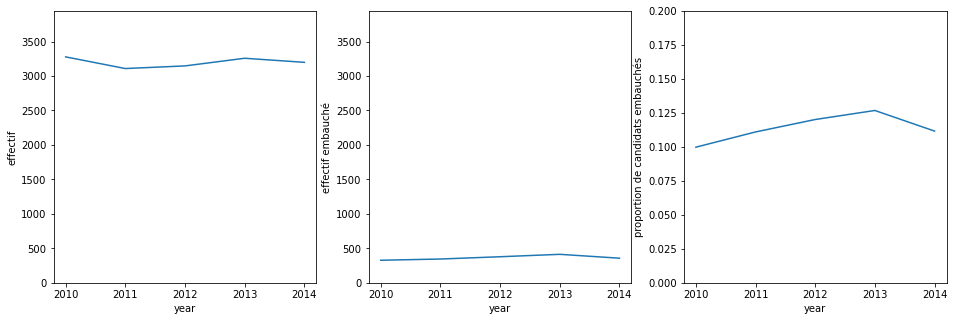

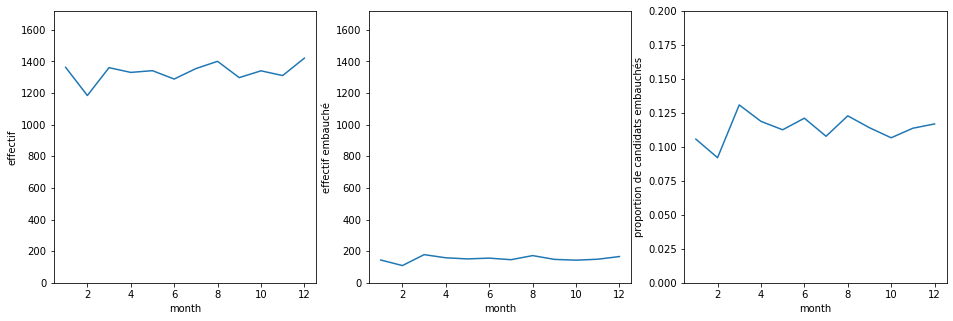

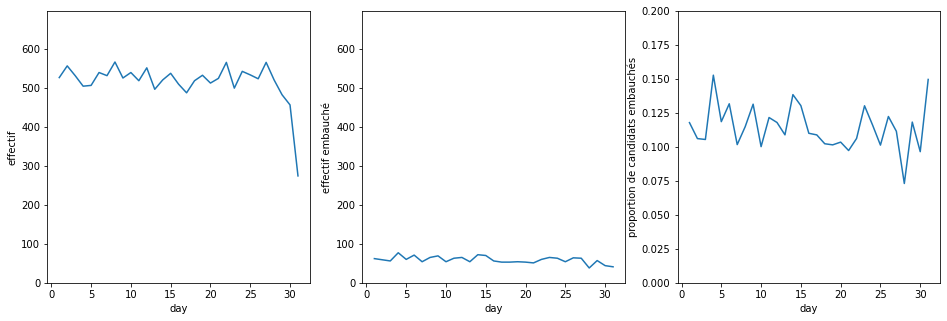

In [11]:
for temp in ['year', 'month', 'day']:

    fig, ax = plt.subplots(1, 3, figsize=(16,5))
    ax[0].plot(df.groupby(temp).size())
    ax[0].set_xlabel(temp)
    ax[0].set_ylabel('effectif')
    ax[0].set_ylim([0, 1.2 * ax[0].get_ylim()[1]])

    ax[1].plot(df.groupby(temp)['embauche'].sum())
    ax[1].set_xlabel(temp)
    ax[1].set_ylabel('effectif embauché')
    ax[1].set_ylim([0, ax[0].get_ylim()[1]])

    ax[2].plot(df.groupby(temp)['embauche'].sum()/df.groupby(temp).size())
    ax[2].set_xlabel(temp)
    ax[2].set_ylabel('proportion de candidats embauchés')
    ax[2].set_ylim([0, 0.2])

### Tests d'indépendance entre les variables

Dans cette partie on teste l'indépendance entre certaines variables du jeu de données: spécialité/sexe (qualitattif/qualitatif), couleur de cheveux/salaire (qualitatif/quantitatif) et expérience/note (quantitatif/quantitatif).

In [12]:
# Test d'indépence entre spécialité et sexe
crosstab = pd.crosstab(df['specialite'], df['sexe'])  # On crée la table de contingence
chi2, p_value, dof, exp = chi2_contingency(crosstab)  # On calcule la statistique du chi2 ainsi que la p-valeur

print('Table de contingence:')
print(crosstab)
print('\n')
print('Effectifs théoriques en cas d\'indépendance:')
print(exp)
print('\n')
print('chi2 = {}'.format(chi2))
print('p-value = {}'.format(p_value))

cramerV = np.sqrt(chi2/(crosstab.sum().sum()))  # Calcul du coefficient de Cramer
print('Coefficient V de Cramer: {}'.format(cramerV))

Table de contingence:
sexe            F     M
specialite             
archeologie   868   223
detective    1995  1296
forage       1601  1907
geologie     1983  6113


Effectifs théoriques en cas d'indépendance:
[[ 439.98980358  651.01019642]
 [1327.22863756 1963.77136244]
 [1414.74264982 2093.25735018]
 [3265.03890905 4830.96109095]]


chi2 = 2145.526975279631
p-value = 0.0
Coefficient V de Cramer: 0.3663507502628702


La p-valeur est égale à 0, on rejette l'hypothèse d'indépendance. Le coefficient V de Cramer quantifie l'intensité de la relation entre la spécialité et le sexe.

In [13]:
# Test d'indépendance entre couleur de cheveux et salaire

# On sépare les données selon la couleur de cheveux
salaire_roux = df[df['cheveux'] == 'roux']['salaire']
salaire_blond = df[df['cheveux'] == 'blond']['salaire']
salaire_chatain = df[df['cheveux'] == 'chatain']['salaire']
salaire_brun = df[df['cheveux'] == 'brun']['salaire']

# On teste la normalité de la distribution des salaires pour chaque couleur de cheveux avec le test de Shapiro-Wilks
for couleur in df['cheveux'].unique():
    
    shapiro_stat, shapiro_p = shapiro(df[df['cheveux'] == couleur]['salaire'])
    print(couleur + ': Shapiro stat = {}, p-valeur = {}'.format(shapiro_stat, shapiro_p))

# On teste l'égalité des variances de chaque population
levene_test = levene(salaire_roux, salaire_blond, salaire_chatain, salaire_brun)
print('\n')
print('Levene stat = {}, p-valeur = {}'.format(levene_test.statistic, levene_test.pvalue))

roux: Shapiro stat = 0.9980597496032715, p-valeur = 0.05609733983874321
blond: Shapiro stat = 0.9996455311775208, p-valeur = 0.5843695998191833
chatain: Shapiro stat = 0.999340832233429, p-valeur = 0.0762011855840683
brun: Shapiro stat = 0.9995392560958862, p-valeur = 0.3136093020439148


Levene stat = 0.9665952183424995, p-valeur = 0.40736319175020486


Les p-valeurs du test de Shapiro sont supérieures à 0.05, on ne rejette pas l'hypothèse d'une distribution normale du salaire pour chaque couleur de cheuveux. De même, la p-valeur de test de Levene est supérieure à 0.05, on considère que les salaires ont la même variance selon la couleur de cheveux. Avec ces deux hypthoèses, on peut appliquer un test d'analyse de la variance à un facteur (one-way ANOVA).

In [14]:
# Test one-way ANOVA

f_oneway_test = f_oneway(salaire_roux, salaire_blond, salaire_chatain, salaire_brun)

print('F-oneway stat = {}, p-valeur = {}'.format(f_oneway_test.statistic, f_oneway_test.pvalue))

F-oneway stat = 23.897578786646598, p-valeur = 2.00260241330107e-15


In [15]:
# Corrélation entre nombre d'années d'expérience et note à l'exercice
spearmanr(df[['exp','note']])

SpearmanrResult(correlation=-0.009115853674802086, pvalue=0.24911416921569593)

## Machine Learning

On va créer un pipeline qui permet à la fois de faire le pre-processing du jeu de données et de procéder à l'entrainement du modèle de machine learning mis en place.

### Pre-processing

In [16]:
# Séparation données d'entrée / variable à prédire
data = df.drop(columns=['embauche'])
label = df['embauche']

# Creation train / test
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=123)  # On fixe la graine pour la reproductibilité du test

In [17]:
# On définit des transformations du jeu de données pour chaque type 

# Conversion des dates du format string au format datetime, on ne va garder que l'année pour entraîner le modèle
def convert_to_datetime(date_col):
    date_col = date_col.squeeze()
    date_feat = pd.to_datetime(date_col, format='%Y-%m-%d')
    
    return pd.DataFrame(date_feat.apply(lambda x: x.year))

datetime_transformer = FunctionTransformer(convert_to_datetime)

# On applique l'encodage one-hot pour les variables catégoriques et on met à l'échelle les variables numériques
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Certains modèles requierent une normalisation des valeurs numériques, ce n'est pas le cas pour l'algorithme de gradient boosting utilisé dans ce notebook
# numerical_transformer = StandardScaler()
numerical_transformer = FunctionTransformer(lambda x: x, lambda x: x)

In [18]:
# L'étape de pre-processing est effectuée avec la transformation suivante des colonnes:
signif_cat_feat = ['cheveux', 'dispo', 'sexe', 'diplome', 'specialite']
signif_num_feat = ['salaire', 'note']
date_feature = ['date']

preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, signif_cat_feat),
        ('num', numerical_transformer, signif_num_feat),
        ('date', datetime_transformer, date_feature)
    ], remainder='drop'
)

### Classification avec un ensemble d'arbre de décision en utilisant xgboost

In [19]:
# Les classes du jeu de données sont déséquilibrées, on utilise le paramètre scale_pos_weight pour tenir compte de ce déséquilibre

scale_pos_weight = 1/y_train.mean()

# Création du pipeline regroupant preprocessing et estimateur
pipe_xgb = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight)),
])

pipe_xgb.fit(x_train, y_train)
y_pred_xgb = pipe_xgb.predict(x_test)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2848
           1       0.43      0.69      0.53       350

    accuracy                           0.87      3198
   macro avg       0.69      0.79      0.73      3198
weighted avg       0.90      0.87      0.88      3198



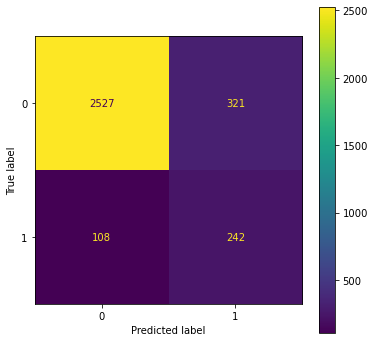

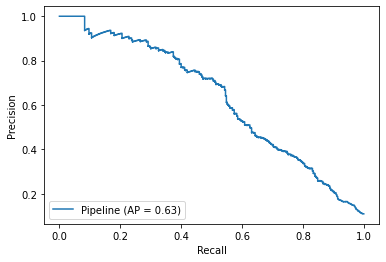

In [20]:
# On calcule différentes métriques d'évaluations et on trace la matrice de confusion
print(classification_report(y_test, y_pred_xgb))

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pipe_xgb, x_test, y_test, ax=ax, normalize=None)

# On trace aussi la courbe précision - rappel
plot_precision_recall_curve(pipe_xgb, x_test, y_test)

In [21]:
# On utilise un seuil à 0.75 pour la prédiction et on recalcule les différentes métriques d'évaluation du modèle
y_proba = pipe_xgb.predict_proba(x_test)
y_thresholded = np.where(y_proba < 0.75, 0, 1)[:, 1]

print(classification_report(y_test, y_thresholded))

# On calcule aussi la matrice de confusion
print(confusion_matrix(y_test, y_thresholded, normalize=None))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2848
           1       0.67      0.55      0.60       350

    accuracy                           0.92      3198
   macro avg       0.81      0.76      0.78      3198
weighted avg       0.91      0.92      0.92      3198

[[2752   96]
 [ 159  191]]


### Importance des paramètres

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

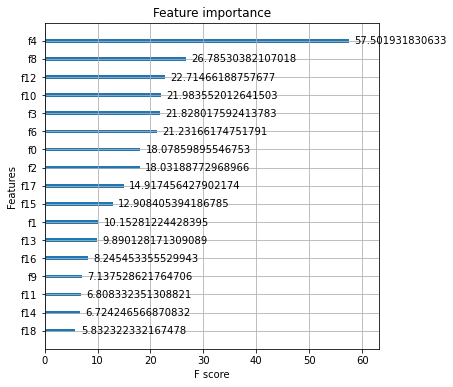

In [22]:
# On trace un premier aperçu de l'importance des variables à l'aide de xgboost
fig, ax = plt.subplots(figsize=(6,6))
plot_importance(pipe_xgb['xgb'], importance_type='gain', ax=ax)

In [23]:
scores = pipe_xgb['xgb'].get_booster().get_score(importance_type='gain')

# On additionne les scores de toutes les colonnes qui décrivent une même variable catégorielle.
score_cheveux = scores['f0'] + scores['f1'] + scores['f2'] + scores['f3']
score_dispo = scores['f4']
score_sexe = scores['f6']
score_diplome = scores['f8'] + scores['f9'] + scores['f10'] + scores['f11']
score_specialite = scores['f12'] + scores['f13'] + scores['f14'] + scores['f15']

print('score_cheveux: {}'.format(score_cheveux))
print('score_dispo: {}'.format(score_dispo))
print('score_sexe: {}'.format(score_sexe))
print('score_diplome: {}'.format(score_diplome))
print('score_specialite: {}'.format(score_specialite))
print('score_salaire: {}'.format(scores['f16']))
print('score_note: {}'.format(scores['f17']))
print('score_year: {}'.format(scores['f18']))

score_cheveux: 68.09131652185492
score_dispo: 57.501931830633
score_sexe: 21.23166174751791
score_diplome: 62.71471680678521
score_specialite: 52.23744201994348
score_salaire: 8.245453355529943
score_note: 14.917456427902174
score_year: 5.832322332167478


In [24]:
# Vérification de la corrélation entre diplôme et couleur de cheveux
crosstab = pd.crosstab(df['diplome'], df['cheveux'])  # On crée la table de contingence
chi2, p_value, dof, exp = chi2_contingency(crosstab) 

print('Table de contingence:')
print(crosstab)
print('\n')
print('Effectifs théoriques en cas d\'indépendance:')
print(exp)
print('\n')
print('chi2 = {}'.format(chi2))
print('p-value = {}'.format(p_value))

cramerV = np.sqrt(chi2/(crosstab.sum().sum()))  # Calcul du coefficient de Cramer
print('Coefficient V de Cramer: {}'.format(cramerV))

Table de contingence:
cheveux   blond  brun  chatain  roux
diplome                             
bac         872   310       70   702
doctorat    161   451     1414    12
licence    2417  1898      976   692
master     1325  2140     2353   193


Effectifs théoriques en cas d'indépendance:
[[ 583.65757538  586.59114225  588.30238959  195.44889278]
 [ 608.74827974  611.80795696  613.59276867  203.85099462]
 [1787.11528838 1796.09764794 1801.33735769  598.44970599]
 [1795.4788565  1804.50325285 1809.76748405  601.25040661]]


chi2 = 4885.0854375693525
p-value = 0.0
Coefficient V de Cramer: 0.5527976365014968


In [25]:
# Vérification de la corrélation entre diplôme et disponibilité
crosstab = pd.crosstab(df['diplome'], df['dispo'])  # On crée la table de contingence
chi2, p_value, dof, exp = chi2_contingency(crosstab) 

print('Table de contingence:')
print(crosstab)
print('\n')
print('Effectifs théoriques en cas d\'indépendance:')
print(exp)
print('\n')
print('chi2 = {}'.format(chi2))
print('p-value = {}'.format(p_value))

cramerV = np.sqrt(chi2/(crosstab.sum().sum()))  # Calcul du coefficient de Cramer
print('Coefficient V de Cramer: {}'.format(cramerV))

Table de contingence:
dispo      non   oui
diplome             
bac       1825   129
doctorat   354  1684
licence   4510  1473
master    2853  3158


Effectifs théoriques en cas d'indépendance:
[[1166.33729513  787.66270487]
 [1216.47666708  821.52333292]
 [3571.2364569  2411.7635431 ]
 [3587.94958088 2423.05041912]]


chi2 = 3425.3646722799776
p-value = 0.0
Coefficient V de Cramer: 0.462896079806917


### Réglage de quelques hyperparamètres de l'algorithme

In [26]:
# On donne un petit exemple de réglage de certains paramètres du modèle
param_grid = {
    'xgb__learning_rate': [0.3, 0.1, 0.7],
    'xgb__max_depth': [6, 2, 10],
    'xgb__n_estimators': [100, 10],
}

tuned_model = GridSearchCV(pipe_xgb, param_grid, scoring='f1')
tuned_model.fit(x_train, y_train)
y_tuned_pred = tuned_model.predict(x_test)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2848
           1       0.55      0.61      0.58       350

    accuracy                           0.90      3198
   macro avg       0.75      0.77      0.76      3198
weighted avg       0.91      0.90      0.90      3198



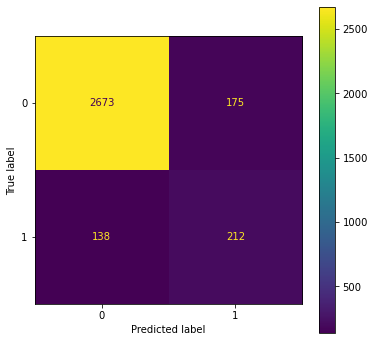

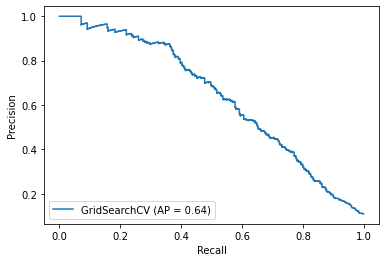

In [27]:
# De nouveau, on calcule les métriques d'évaluation du modèle
print(classification_report(y_test, y_tuned_pred))

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(tuned_model, x_test, y_test, ax=ax, normalize=None)
plot_precision_recall_curve(tuned_model, x_test, y_test)

In [28]:
# On utilise un seuil à 0.75 pour la prédiction et on recalcule les différentes métriques d'évaluation du modèle
y_proba = pipe_xgb.predict_proba(x_test)
y_thresholded = np.where(y_proba < 0.75, 0, 1)[:, 1]

print(classification_report(y_test, y_thresholded))
print(confusion_matrix(y_test, y_thresholded, normalize=None))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2848
           1       0.67      0.55      0.60       350

    accuracy                           0.92      3198
   macro avg       0.81      0.76      0.78      3198
weighted avg       0.91      0.92      0.92      3198

[[2752   96]
 [ 159  191]]
